In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob

import dist_analy.pca
from dist_analy.determine_seq import get_and_align_sequence, get_conserved, get_klifs_res, def_union
from dist_analy.util.pdb_info import pdb_csv, get_any_info, pdb_read_csv

from docking_poses.crd_utils import sRMSD, get_crd_symmetry_rmsd, save_str, \
        sRMSD_from_str, load_struct, align_lig, docking_accuracy, get_sd_results, get_crd_results, \
        metric_list, metric_list_linf9, metric_list_vina, metric_list_dyn, read_vina, get_pose_cluster_dict

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### load cluster definitions
including the receptor only time-split

In [166]:
sd_cdk2 = pd.read_csv("docking_poses/cdk2_selfdock.csv", index_col=0)


In [167]:
ro_pca = pd.read_csv("docking_poses/ro_pca.240429.csv", index_col=0).rename(columns={"rec_clust":"ro_label"})
lo_pca = pd.read_csv("docking_poses/lo_pca.240916.csv", index_col=0).rename(columns={"label":"lo_label"})
ro_ts_pca = pd.read_csv("docking_poses/ro_pca.240916.time_split.csv", index_col=0).rename(columns={"rec_clust":"ro_label"})

lo_pca["PDB_chain_LIG"] = lo_pca.PDB_chain_lig_resnum.str[:10]
lo_pca = lo_pca.loc[lo_pca.PDB_chain_LIG.isin(sd_cdk2.PDB_chain_LIG)]

#### load docking input files and docking results
- the code used to traditional docking self-/cross-docking RMSD/centroid distances is below in the jupyter notebook
    - for cross-docking, perform an additional step of all-Ca superimposition before hand 
- we wrote a script for diffdock and dynbind to evaluate self-/cross-docking RMSD/centroid distances natively 
- we include the traditional docking self-/cross-docking metric calculations within the jupyter notebook because
the workflow for traditional docking included parallelization


In [168]:
sd_cdk2 = sd_cdk2.merge(ro_pca.rename(columns={"PDB_chain":"PDB_chain_org"})[["PDB_chain_org", "ro_label"]], how="left", on="PDB_chain_org")\
       .merge(lo_pca[["PDB_chain_LIG", "lo_label"]], how="left", on="PDB_chain_LIG")
sd_cdk2["lig_lr_label"] = list(zip(sd_cdk2.ro_label, sd_cdk2.lo_label))

In [169]:
allo_crd = pd.read_csv("docking_poses/self_cross_dock.csv", index_col=0)
allo_crd["ind"] = allo_crd.index
allo_crd = allo_crd.merge(sd_cdk2[["LIG", "lig_lr_label"]], on=["LIG"]).drop_duplicates(["PDB_chain_LIG", "lig_lr_label"])

In [170]:
def get_df(dir_name):
    names = np.load(f"{dir_name}complex_names.npy",allow_pickle=True)
    rmsds = np.load(f"{dir_name}rmsds.npy",allow_pickle=True).flatten()
    centroid_distances = np.load(f"{dir_name}centroid_distances.npy",allow_pickle=True).flatten()
    confidences = np.load(f"{dir_name}confidences.npy",allow_pickle=True).flatten()

    ind = [i for i in range(len(names)) for j in range(1,11)]
    names_flat = [i for i in names for j in range(1,11)]
    df_out = pd.DataFrame(zip(names_flat, ind, confidences, rmsds, centroid_distances), columns=["name", "ind", "confidence", "RMSD", "cent_dist"])
    df_out['PDB_chain'] = df_out.name.str.split('-',expand=True)[0]
    df_out['LIG'] = df_out.name.str.split('-',expand=True)[1]

    df_out=df_out.sort_values('confidence', ascending=False)\
                 .groupby(["name", "ind"])[df_out.columns]\
                 .apply(lambda group: group.assign(rank=group['confidence'].rank(method='dense', ascending=False).astype(int)))\
                 .reset_index(drop=True)\
                 .drop_duplicates()
    
    # rank = [j for i in range(len(names)) for j in range(1,11)]
    return(df_out)

In [171]:
# loading the diffdock-2023 data
dd_conf = np.load("docking_poses/DiffDock_2023/confidences.npy")

sd_1 = allo_crd.merge(sd_cdk2[["PDB_chain_LIG", "ref_lig"]], on="PDB_chain_LIG", how="inner")
sd_2 = pd.concat([sd_1[['ind','protein_path', 'ligand', 'PDB_fn', 'PDB', 'PDB_chain', 'LIG','PDB_chain_LIG', 'ref_lig', 'ro_label', 'lo_label']]]*10, ignore_index=True).sort_values(["ind"])
sd_2['rank'] = np.tile(np.arange(1, 11), len(sd_1))
sd_2 = sd_2.sort_values(["ind", "rank"], ascending=[True, True]).reset_index(drop=True)
sd_2["confidence"] = dd_conf[sd_1["ind"],].flatten()
sd_2_LRD = sd_2.copy(deep=True)
# sd_2_vina = sd_2.copy(deep=True)

In [172]:
# load vina data
out_path = "docking_poses/vina/self_cross_dock/"
sd_2_vina = []

for _, row in sd_1.iterrows():
    i = row.ind
    ref_lig = row.ref_lig
    lig_fns = sorted(glob(f'{out_path}/index{i}/*_*.pdbqt'), key=lambda x: int(os.path.basename(x).split('.')[0].split('_')[1]))
    vina_out_str = [read_vina(lig_fn) for lig_fn in lig_fns]

    lig_fn_conf = [int(os.path.basename(lig_fn).split('.')[0].split('_')[1]) for lig_fn in lig_fns]
    for conf_out_str, conf in zip(vina_out_str, lig_fn_conf):
        row1 = row.copy()
        for conf_rank, rank_out_str in enumerate(conf_out_str):
            RMSD, cent_dist = sRMSD("".join(rank_out_str), ref_lig, mol1_type="pdbqt_out_str")
            row1["conf"]=conf
            row1["conf_rank"]=conf_rank+1
            row1["RMSD"]=RMSD
            row1["cent_dist"]=cent_dist
            sd_2_vina.append(row1.to_dict())

sd_2_vina = pd.DataFrame.from_records(sd_2_vina) 
vina = pd.read_csv("docking_poses/vina/scores.1.csv")
vina = vina.sort_values('pVina', ascending=False)\
         .groupby(["PDB_chain","LIG"])[vina.columns]\
         .apply(lambda group: group.assign(rank=group['pVina'].rank(method='dense', ascending=False).astype(int)), include_groups=False)\
         .reset_index(drop=True)
sd_2_vina = sd_2_vina.merge(vina.rename(columns={"conf_id":"conf"})[["ind", "conf", "pVina", "conf_rank", "rank"]], on=["ind", "conf", "conf_rank"], how="left")

In [173]:
# load lin_f9 data
out_path = "docking_poses/lin_f9/self_cross_dock/"
sd_2_linf9 = []

for _, row in sd_1.iterrows():
    i = row.ind
    ref_lig = row.ref_lig
    lig_fns = sorted(glob(f'{out_path}/index{i}/*_*.pdbqt'), key=lambda x: int(os.path.basename(x).split('.')[0].split('_')[1]))
    lig_fn_conf = [int(os.path.basename(lig_fn).split('.')[0].split('_')[1]) for lig_fn in lig_fns]
    linf9_out_str = [read_vina(lig_fn) for lig_fn in lig_fns]

    for conf_out_str, conf in zip(linf9_out_str, lig_fn_conf):
        row1 = row.copy()
        for conf_rank, rank_out_str in enumerate(conf_out_str):
            RMSD, cent_dist = sRMSD("".join(rank_out_str), ref_lig, mol1_type="pdbqt_out_str")
            row1["conf"]=conf
            row1["conf_rank"]=conf_rank+1
            row1["RMSD"]=RMSD
            row1["cent_dist"]=cent_dist
            sd_2_linf9.append(row1.to_dict())

sd_2_linf9 = pd.DataFrame.from_records(sd_2_linf9) 
linf9 = pd.read_csv("docking_poses/lin_f9/scores.1.csv")
linf9 = linf9.sort_values('pLin_F9', ascending=False)\
         .groupby(["PDB_chain","LIG"])[linf9.columns]\
         .apply(lambda group: group.assign(rank=group['pLin_F9'].rank(method='dense', ascending=False).astype(int)), include_groups=False)\
         .reset_index(drop=True)
sd_2_linf9 = sd_2_linf9.merge(linf9.rename(columns={"conf_id":"conf"})[["ind", "conf", "pLin_F9", "conf_rank", "rank"]], on=["ind", "conf", "conf_rank"], how="left")

In [174]:
## get DiffDock and DiffDock-Lin_F9 LRD data
rmsd_l, cent_dist_l = [], [] 
rmsd_l_LRD, cent_dist_l_LRD = [], []

out_path = "docking_poses/DiffDock_2023/self_cross_dock/"
out_path_LRD = "docking_poses/DiffDock_LRD/self_cross_dock/"

for i, ref_lig in zip(sd_1.ind, sd_1.ref_lig):
    lig_fns = sorted(glob(f'{out_path}/index{i}/rank*_*.sdf'), key=lambda x: int(os.path.basename(x).split('_')[0].split('.')[0][4:]))
    for lig in lig_fns:
        RMSD, cent_dist = sRMSD(ref_lig, lig)
        rmsd_l.append(RMSD)
        cent_dist_l.append(cent_dist)

    lig_fns = sorted(glob(f'{out_path_LRD}/index{i}/rank*.pdb'), key=lambda x: int(os.path.basename(x).split('_')[0].split('.')[0][4:]))
    for lig in lig_fns:
        RMSD, cent_dist = sRMSD(ref_lig, lig)
        rmsd_l_LRD.append(RMSD)
        cent_dist_l_LRD.append(cent_dist)

sd_2["RMSD"] = rmsd_l
sd_2["cent_dist"] = cent_dist_l
sd_2_LRD["RMSD"] = rmsd_l_LRD
sd_2_LRD["cent_dist"] = cent_dist_l_LRD

In [175]:
sd_cdk2_tmp = sd_cdk2.drop_duplicates(["lig_lr_label", "LIG"])

In [176]:
dd_S_dir = "docking_poses/DiffDock-S/"
df_S = get_df(dd_S_dir)

df_S["PDB_chain_LIG"] = df_S.PDB_chain.astype(str) + "_" + df_S.LIG.astype(str)
df_S["ro_label"] = df_S.PDB_chain.apply(lambda x: ro_pca[ro_pca.PDB_chain==x].ro_label.values[0])
df_S = df_S.merge(lo_pca[["LIG", "lo_label"]].drop_duplicates("LIG"), how="left", on="LIG") #.LIG.apply(lambda x: lo_pca[lo_pca.LIG==x].lo_label.values[0])
df_S["lig_lr_label"] = df_S.LIG.apply(lambda x: sd_cdk2_tmp[sd_cdk2_tmp.LIG==x].lig_lr_label.values[0] )
df_S.set_index(["name", "ind", "PDB_chain", "LIG", "rank"])
df_S_sd = df_S[df_S.PDB_chain_LIG.isin(sd_cdk2.PDB_chain_LIG)]

In [177]:
dd_L_dir = "docking_poses/DiffDock-L/"
df_L = get_df(dd_L_dir)
df_L["PDB_chain_LIG"] = df_L.PDB_chain.astype(str) + "_" + df_L.LIG.astype(str)
df_L["ro_label"] = df_L.PDB_chain.apply(lambda x: ro_pca[ro_pca.PDB_chain==x].ro_label.values[0])
df_L = df_L.merge(lo_pca[["LIG", "lo_label"]].drop_duplicates("LIG"), how="left", on="LIG") #.LIG.apply(lambda x: lo_pca[lo_pca.LIG==x].lo_label.values[0])
df_L["lig_lr_label"] = df_L.LIG.apply(lambda x: sd_cdk2_tmp[sd_cdk2_tmp.LIG==x].lig_lr_label.values[0] )
df_L.set_index(["name", "ind", "PDB_chain", "LIG", "rank"])
df_L_sd = df_L[df_L.PDB_chain_LIG.isin(sd_cdk2.PDB_chain_LIG)]


In [178]:
df_dyn = pd.read_csv("docking_poses/DynBind/complete_affinity_prediction.csv", index_col=0)

df_dyn["PDB_chain_LIG"] = df_dyn.PDB_chain.astype(str) + "_" + df_dyn.LIG.astype(str)
df_dyn["ro_label"] = df_dyn.PDB_chain.apply(lambda x: ro_pca[ro_pca.PDB_chain==x].ro_label.values[0])
df_dyn = df_dyn.merge(lo_pca[["LIG", "lo_label"]].drop_duplicates("LIG"), how="left", on="LIG") #.LIG.apply(lambda x: lo_pca[lo_pca.LIG==x].lo_label.values[0])
df_dyn["lig_lr_label"] = df_dyn.LIG.apply(lambda x: sd_cdk2_tmp[sd_cdk2_tmp.LIG==x].lig_lr_label.values[0] )
df_dyn_sd = df_dyn[df_dyn.PDB_chain_LIG.isin(sd_cdk2.PDB_chain_LIG)]

## calculate self docking results
- report the fraction of complexes predicted successfully, organized by the binding mode

In [179]:
vina_sd_results = get_sd_results(sd_2_vina, metric_list_vina)
linf9_sd_results = get_sd_results(sd_2_linf9, metric_list_linf9)
dd_sd_results= get_sd_results(sd_2, metric_list)
ddS_sd_results = get_sd_results(df_S_sd, metric_list)
ddL_sd_results = get_sd_results(df_L_sd, metric_list)
dyn_sd_results = get_sd_results(df_dyn_sd, metric_list_dyn)
ddLRD_sd_results= get_sd_results(sd_2_LRD, metric_list)

In [180]:
metric = "all_RMSD_lt2"
binding_modes = [(1,1), (1,0), (2,0)]
for sd in [vina_sd_results[metric], linf9_sd_results[metric], \
            dd_sd_results[metric], \
            ddL_sd_results[metric], ddS_sd_results[metric], \
            dyn_sd_results[metric],\
            ddLRD_sd_results[metric] ]:
    print(" & ".join([f"{float(sd[j]['average']):0.3f}" for j in binding_modes]))

1.000 & 0.625 & 0.625
1.000 & 0.500 & 0.500
0.000 & 1.000 & 1.000
0.000 & 1.000 & 1.000
0.000 & 1.000 & 1.000
0.000 & 0.875 & 1.000
0.429 & 0.375 & 0.500


<>:28: DeprecationWarning: invalid escape sequence \m
<>:28: DeprecationWarning: invalid escape sequence \m
/var/folders/jl/s240_98s79n5zdzp911g1tzc0000gr/T/ipykernel_78306/2434985453.py:28: DeprecationWarning: invalid escape sequence \m
  ax.set_xlabel('Fraction of complexes successfully\npredicted (RMSD < 2 $\mathrm{\AA}$)', fontsize=13)


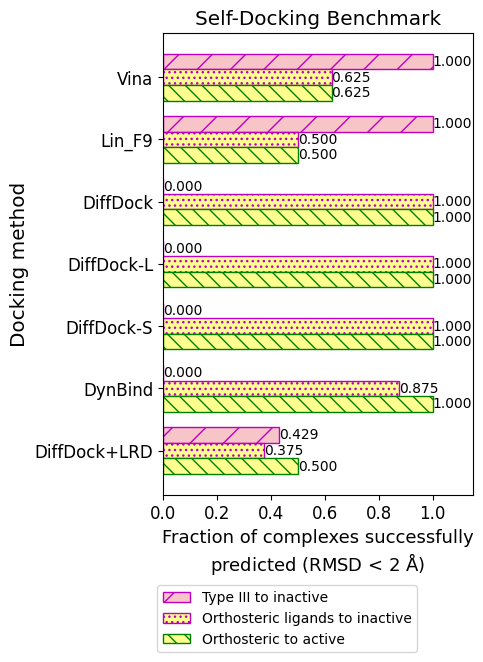

In [185]:
colors = ['#f7c4c8', '#FFFF8F', '#FFFF8F']
outlines = ['m', 'm', 'green']
hatches = ['/', '...', '\\\\']
labels = ["Type III to inactive", "Orthosteric ligands to inactive", "Orthosteric to active"]
# Plot the bar chart
fig, ax = plt.subplots(figsize=(4, 6))
height = 0.25 
average_values = []
for sd in [vina_sd_results[metric], linf9_sd_results[metric], 
            dd_sd_results[metric], 
            ddL_sd_results[metric], ddS_sd_results[metric], 
            dyn_sd_results[metric],
            ddLRD_sd_results[metric]]:
    average_values.append([float(sd[j]['average']) for j in binding_modes])
average_values = list(zip(*average_values))

# Transpose the list to group by binding modes
for i, (values, color, outline, hatch, lab) in enumerate(zip(average_values, colors, outlines, hatches, labels)):
    bars = ax.barh([x + (i-1) * height for x in range(len(values))], values, height=height, 
                   color=color, edgecolor=outline, hatch=hatch, label=lab)
    for bar in bars:
        bar.set_hatch(hatch)
        bar.set_edgecolor(outline)
        ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{bar.get_width():.3f}', va='center', ha='left')

ax.invert_yaxis()
ax.set_ylabel('Docking method')
ax.set_xlabel('Fraction of complexes successfully\npredicted (RMSD < 2 $\mathrm{\AA}$)', fontsize=13)
ax.set_title('Self-Docking Benchmark')
ax.legend(bbox_to_anchor=(0.4, -0.18), loc='upper center', ncol=1, fontsize='medium')
ax.set_xlim(0,1.15)
docking_methods = ['Vina', 'Lin_F9', 'DiffDock', 'DiffDock-L', 'DiffDock-S', 'DynBind', 'DiffDock+LRD']
ax.set_yticks(range(len(docking_methods)))
ax.set_yticklabels(docking_methods)
# plt.show()
# plt.show()
plt.savefig("/Users/eac709/Desktop/CDK2-Manuscript/figures/self_docking_benchmark.png", dpi=600, bbox_inches='tight')

In [42]:
print("Top-1/-5 ranked results")

binding_modes = [(1,1), (1,0), (2,0)]
for sd_res in [vina_sd_results, linf9_sd_results, \
            dd_sd_results, \
            ddL_sd_results, ddS_sd_results, \
            dyn_sd_results,\
            ddLRD_sd_results ]:

    print(" & ".join([f"{float(sd_res[metric][j]['average']):0.2f}" for j in binding_modes for metric in ["top5_RMSD_lt2", "top1_RMSD_lt2"]]))

Top-1/-5 ranked results
1.00 & 1.00 & 0.38 & 0.38 & 0.50 & 0.25
1.00 & 1.00 & 0.38 & 0.00 & 0.50 & 0.50
0.00 & 0.00 & 1.00 & 1.00 & 0.88 & 0.88
0.00 & 0.00 & 1.00 & 1.00 & 1.00 & 1.00
0.00 & 0.00 & 1.00 & 0.88 & 1.00 & 0.88
0.00 & 0.00 & 0.88 & 0.75 & 1.00 & 0.88
0.43 & 0.14 & 0.38 & 0.12 & 0.50 & 0.50


## crd
- below is example code for the superimposition
- jupyter notebook code for loading the x-ray structures
- align x-ray structures to the docked complexes using all-ca
- calculate RMSD and centroid distance
- report the fraction of complexes predicted successfully, organized by the binding mode and time-split receptor conformation


In [186]:
pdb_path = "docking_poses/receptor/CDK2_fastH/"
lig_path = "datafiles/lig_pdb_all/"
all_model_path = "docking_poses/receptor/CDK2_allmodel"
cdk2_all_model = ['1FIN_A', '1FIN_C', '1FVV_A', '1FVV_C', '1JST_A', '1JST_C', '1PF8_A', '1VYW_A', '1VYW_C', '1YKR_A', '2B54_A', '2BKZ_A', '2BPM_A', '2BPM_C', '2C4G_C', '2EXM_A', '2G9X_A', '2WIH_A', '2WIH_C', '2WPA_A', '2WPA_C', '2WXV_A', '2WXV_C', '3DDP_C', '3F5X_C', '3PXF_A', '3PXZ_A', '3PY1_A', '4BCO_A', '4BCP_A', '4CFV_A', '4CFW_A', '4CFX_A', '4CFX_C', '4EON_A', '4EZ7_A', '4FX3_A', '4FX3_C', '4GCJ_A', '4KD1_A', '5CYI_A', '5IF1_A', '6P3W_A', '6YL6_A', '7E34_A', '7RWF_A']
dataset_dir = "datafiles/crd_dataset/"

unique_lig = allo_crd.LIG.unique()
unique_PDB_chain = allo_crd.PDB_fn.unique()

lig_dir_all = []
for lig in unique_lig:
    # tup: (pdb_name, pdb_chain, lig_name, lig_chain, pdb_lig_dir)
    # will need to change this when aligning peptide complexes
    lig_dir_all.extend([(os.path.basename(ldir)[:6], os.path.basename(ldir)[5], \
        os.path.basename(ldir)[7:], os.path.basename(ldir)[5], ldir) for ldir in glob(f"{dataset_dir}/*{lig}*")])
        
# load pdb and ligand structures into data object
samp_pdb_dict = load_struct([(glob(f"{lig_dir}/{pdb}.pdb")[0], pdb_chain, f"{pdb}_{lig}") for (pdb, pdb_chain, lig, _, lig_dir) in lig_dir_all])
samp_lig_dict = load_struct([(glob(f"{lig_dir}/{pdb}_{lig}.pdb")[0], lig_chain, f"{pdb}_{lig}") for (pdb, _, lig, lig_chain, lig_dir) in lig_dir_all])

modeller_pdb_list = [(f'{all_model_path}/{pdb[:6]}.pdb' if pdb in cdk2_all_model else f'{pdb_path}/{pdb}.pdb', pdb[5], pdb) for pdb in unique_PDB_chain]
ref_pdb_dict = load_struct(modeller_pdb_list)


In [187]:
from copy import deepcopy 

## for each structure, align all other structures and output the aligned ligand with a string
align_ref = {} 
for ref, ref_dict in ref_pdb_dict.items():
    t_ref = deepcopy(ref_dict['struct'])
    for samp, samp_dict in samp_pdb_dict.items():
        lig = samp.split('_')[-2]
        res_num = samp.split('_')[-1]
        samp_pdb = samp[:6]
        t_samp = deepcopy(samp_dict['struct'])
        s_lig = deepcopy(samp_lig_dict[samp]['struct'])
        out_str = align_lig(t_ref, t_samp, s_lig, samp_lig_dict[samp]['chain'], range(1,299))

        # we are aligning the samp structure to ref...
        # sometimes we will have multiple complexes with the same ligand
        # add the outputted ligand to the complex
        try:
            align_ref[f"{ref}-{lig}"].update({f"{samp}": out_str})
        except KeyError:
            # dict_x[key] = [value]
            align_ref[f"{ref}-{lig}"] = {f"{samp}": out_str}

In [188]:
allo_crd = allo_crd.loc[allo_crd.PDB_chain.isin(ro_ts_pca.PDB_chain)].reset_index(drop=True)

allo_crd_1 = allo_crd[~allo_crd.PDB_chain_LIG.isin(sd_cdk2.PDB_chain_LIG)]
allo_crd_2 = pd.concat([allo_crd_1[['ind','protein_path', 'ligand', 'PDB_fn', 'PDB', 'PDB_chain', 'LIG','PDB_chain_LIG', 'ro_label', 'lo_label', "lig_lr_label"]]]*10, ignore_index=True).sort_values(["ind"])
allo_crd_2['rank'] = np.tile(np.arange(1, 11), len(allo_crd_1))
allo_crd_2 = allo_crd_2.sort_values(["ind", "rank"], ascending=[True, True]).reset_index(drop=True)
allo_crd_2["confidence"] = dd_conf[allo_crd_1["ind"],].flatten()
allo_crd_2_LRD = allo_crd_2.copy()

In [189]:
out_path = "docking_poses/vina/self_cross_dock/"
crd_vina = []

for _, row in allo_crd_1.iterrows():
    i = row.ind
    pdb_fn = row.PDB_fn
    lig = row.LIG

    lig_fns = sorted(glob(f'{out_path}/index{i}/*_*.pdbqt'), \
                     key=lambda x: int(os.path.basename(x).split('.')[0].split('_')[1]))
    lig_fn_conf = [int(os.path.basename(lig_fn).split('.')[0].split('_')[1]) for lig_fn in lig_fns]
    vina_out_str = [read_vina(lig_fn) for lig_fn in lig_fns]

    for conf_out_str, conf in zip(vina_out_str, lig_fn_conf):
        row1 = row.copy()
        for conf_rank, rank_out_str in enumerate(conf_out_str):
            tmp_rmsd, tmp_cent_dist = [], []
            for res_num, out_str in align_ref[f'{pdb_fn}-{lig}'].items():
                RMSD, cent_dist = sRMSD("".join(rank_out_str), out_str, mol1_type="pdbqt_out_str", mol2_type="out_str")
                tmp_rmsd.append(RMSD)
                tmp_cent_dist.append(cent_dist)
            row1["conf"]=conf
            row1["conf_rank"]=conf_rank+1
            row1["RMSD"]=min(tmp_rmsd)
            row1["cent_dist"]=min(tmp_cent_dist)
            crd_vina.append(row1.to_dict())

crd_vina = pd.DataFrame.from_records(crd_vina)
vina = pd.read_csv("docking_poses/vina/scores.1.csv")
vina = vina.sort_values('pVina', ascending=False)\
         .groupby(["PDB_chain","LIG"])[vina.columns]\
         .apply(lambda group: group.assign(rank=group['pVina'].rank(method='dense', ascending=False).astype(int)))\
         .reset_index(drop=True)
crd_vina = crd_vina.merge(vina.rename(columns={"conf_id":"conf"})[["ind", "conf", "pVina", "conf_rank", "rank"]], on=["ind", "conf", "conf_rank"], how="left")

In [190]:
out_path = "docking_poses/lin_f9/self_cross_dock/"
crd_linf9 = []

for _, row in allo_crd_1.iterrows():
    i = row.ind
    pdb_fn = row.PDB_fn
    lig = row.LIG

    lig_fns = sorted(glob(f'{out_path}/index{i}/*_*.pdbqt'), \
                     key=lambda x: int(os.path.basename(x).split('.')[0].split('_')[1]))
    lig_fn_conf = [int(os.path.basename(lig_fn).split('.')[0].split('_')[1]) for lig_fn in lig_fns]
    linf9_out_str = [read_vina(lig_fn) for lig_fn in lig_fns]

    for conf_out_str, conf in zip(linf9_out_str, lig_fn_conf):
        row1 = row.copy()
        for conf_rank, rank_out_str in enumerate(conf_out_str):
            tmp_rmsd, tmp_cent_dist = [], []
            for res_num, out_str in align_ref[f'{pdb_fn}-{lig}'].items():
                RMSD, cent_dist = sRMSD("".join(rank_out_str), out_str, mol1_type="pdbqt_out_str", mol2_type="out_str")
                tmp_rmsd.append(RMSD)
                tmp_cent_dist.append(cent_dist)
            row1["conf"]=conf
            row1["conf_rank"]=conf_rank+1
            row1["RMSD"]=min(tmp_rmsd)
            row1["cent_dist"]=min(tmp_cent_dist)
            crd_linf9.append(row1.to_dict())

crd_linf9 = pd.DataFrame.from_records(crd_linf9) 
linf9 = pd.read_csv("docking_poses/lin_f9/scores.1.csv")
linf9 = linf9.sort_values('pLin_F9', ascending=False)\
         .groupby(["PDB_chain","LIG"])[linf9.columns]\
         .apply(lambda group: group.assign(rank=group['pLin_F9'].rank(method='dense', ascending=False).astype(int)))\
         .reset_index(drop=True)
crd_linf9 = crd_linf9.merge(linf9.rename(columns={"conf_id":"conf"})[["ind", "conf", "pLin_F9", "conf_rank", "rank"]], on=["ind", "conf", "conf_rank"], how="left")

In [191]:
out_path = "docking_poses/DiffDock_2023/self_cross_dock/"

# crd_stats, crd_LRD_stats = [], []s
rmsd_l, cent_dist_l = [], []

for _, row in allo_crd_1.iterrows():
    i = row.ind
    pdb_fn = row.PDB_fn
    lig = row.LIG

    lig_fns = sorted(glob(f'{out_path}/index{i}/rank*_*.sdf'), key=lambda x: int(os.path.basename(x).split('_')[0].split('.')[0][4:]))

    for lig_fn in lig_fns:
        tmp_rmsd, tmp_cent_dist = [], []
        for res_num, out_str in align_ref[f'{pdb_fn}-{lig}'].items():
            RMSD, cent_dist = sRMSD_from_str(lig_fn, out_str)
            tmp_rmsd.append(RMSD)
            tmp_cent_dist.append(cent_dist)
        rmsd_l.append(min(tmp_rmsd))
        cent_dist_l.append(min(tmp_cent_dist))
    #     break
    # break
allo_crd_2["RMSD"] = rmsd_l
allo_crd_2["cent_dist"] = cent_dist_l

In [192]:
out_path_LRD = "docking_poses/DiffDock_LRD/self_cross_dock/"
rmsd_l_LRD, cent_dist_l_LRD = [], []

for _, row in allo_crd_1.iterrows():
    i = row.ind
    pdb_fn = row.PDB_fn
    lig = row.LIG

    lig_fns = sorted(glob(f'{out_path_LRD}/index{i}/rank*.pdb'), key=lambda x: int(os.path.basename(x).split('_')[0].split('.')[0][4:]))

    for lig_fn in lig_fns:
        tmp_rmsd, tmp_cent_dist = [], []
        for res_num, out_str in align_ref[f'{pdb_fn}-{lig}'].items():
            try:
                RMSD, cent_dist = sRMSD_from_str(lig_fn, out_str)
                tmp_rmsd.append(RMSD)
                tmp_cent_dist.append(cent_dist)
            except:
                print("failed on:", pdb_fn, lig_fn)
                tmp_rmsd.append(None)
                tmp_cent_dist.append(None)
        rmsd_l_LRD.append(min(tmp_rmsd))
        cent_dist_l_LRD.append(min(tmp_cent_dist))

allo_crd_2_LRD["RMSD"] = rmsd_l_LRD
allo_crd_2_LRD["cent_dist"] = cent_dist_l_LRD

lrd_linf9 = pd.read_csv("docking_poses/DiffDock_LRD/scores.csv", index_col=0)
allo_crd_2_LRD = allo_crd_2_LRD.merge(lrd_linf9.rename(columns={"index":"ind"})[["ind", "rank", "pLin_F9_DD_LRD"]], on=["ind", "rank"], how="left")

In [193]:
df_S = df_S.loc[df_S.PDB_chain.isin(ro_ts_pca.PDB_chain)].reset_index(drop=True)
df_S_crd = df_S[~df_S.PDB_chain_LIG.isin(sd_cdk2.PDB_chain_LIG)]


In [194]:
df_L = df_L.loc[df_L.PDB_chain.isin(ro_ts_pca.PDB_chain)].reset_index(drop=True)
df_L_crd = df_L[~df_L.PDB_chain_LIG.isin(sd_cdk2.PDB_chain_LIG)]


In [195]:
df_dyn = df_dyn.loc[df_dyn.PDB_chain.isin(ro_ts_pca.PDB_chain)].reset_index(drop=True)
df_dyn_crd = df_dyn[~df_dyn.PDB_chain_LIG.isin(sd_cdk2.PDB_chain_LIG)]


In [196]:
vina_crd_results = get_crd_results(crd_vina, metric_list_vina)
linf9_crd_results = get_crd_results(crd_linf9, metric_list_linf9)
dd_crd_results = get_crd_results(allo_crd_2, metric_list)
ddS_crd_results = get_crd_results(df_S_crd, metric_list)
ddL_crd_results = get_crd_results(df_L_crd, metric_list)
dyn_crd_results = get_crd_results(df_dyn_crd, metric_list_dyn)
ddLRD_crd_results= get_crd_results(allo_crd_2_LRD, metric_list)


In [197]:
print("cross-docking results: centroid distance < 5 A")

metric = "all_cent_dist_lt5"
binding_modes = [(1,0), (2,0)]
for crd in [vina_crd_results[metric], linf9_crd_results[metric], \
            dd_crd_results[metric], \
            ddL_crd_results[metric], ddS_crd_results[metric], \
            dyn_crd_results[metric],\
            ddLRD_crd_results[metric] ]:
    print(" & ".join([f"{float(crd[i][j]):0.3f}" for i in binding_modes for j in [1,3,2]]))
print('---')
binding_mode = (1,1)
for crd in [vina_crd_results[metric], linf9_crd_results[metric], \
            dd_crd_results[metric], \
            ddL_crd_results[metric], ddS_crd_results[metric], \
            dyn_crd_results[metric],\
            ddLRD_crd_results[metric] ]:
    print(" & ".join([f"{float(crd[binding_mode][j]):0.3f}" for j in [1,3,2]]))

cross-docking results: centroid distance < 5 A
0.929 & 0.667 & 0.984 & 0.873 & 0.708 & 1.000
0.911 & 0.958 & 1.000 & 0.952 & 0.792 & 1.000
1.000 & 0.958 & 1.000 & 1.000 & 1.000 & 1.000
1.000 & 1.000 & 1.000 & 1.000 & 1.000 & 1.000
1.000 & 1.000 & 1.000 & 1.000 & 1.000 & 1.000
1.000 & 1.000 & 1.000 & 1.000 & 1.000 & 1.000
1.000 & 0.958 & 1.000 & 0.984 & 0.958 & 1.000
---
0.000 & 0.762 & 0.000
0.089 & 0.143 & 0.000
0.000 & 0.143 & 0.000
0.000 & 0.071 & 0.000
0.000 & 0.000 & 0.000
0.000 & 0.000 & 0.000
0.000 & 0.952 & 0.000


<>:29: DeprecationWarning: invalid escape sequence \m
<>:29: DeprecationWarning: invalid escape sequence \m
/var/folders/jl/s240_98s79n5zdzp911g1tzc0000gr/T/ipykernel_78306/2185706820.py:29: DeprecationWarning: invalid escape sequence \m
  ax.set_xlabel('Fraction of complexes successfully\npredicted (all-Cα alignment,\nligand-centroid distance < 5 $\mathrm{\AA}$)', fontsize=13)


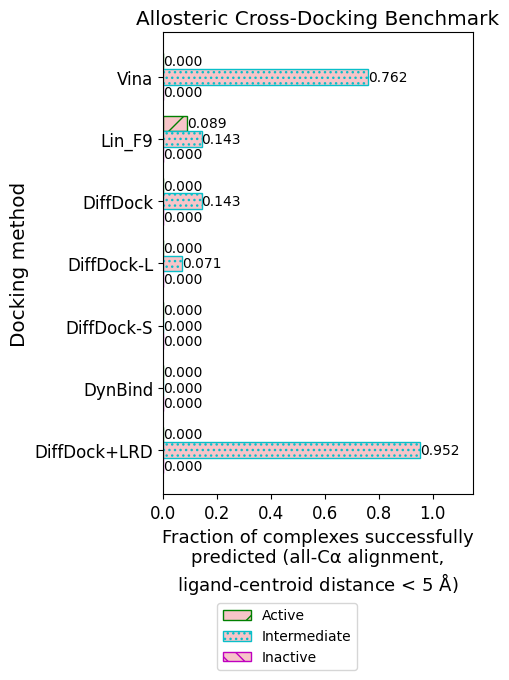

In [198]:
colors = ['#f7c4c8', '#f7c4c8', '#f7c4c8']
outlines = ['green', '#09BFC9', 'm']
hatches = ['/', '...', '\\\\']
labels = ["Active", "Intermediate", "Inactive"]
# Plot the bar chart
fig, ax = plt.subplots(figsize=(4, 6))
height = 0.25 
average_values = []
binding_mode = (1,1)
for crd in [vina_crd_results[metric], linf9_crd_results[metric], \
            dd_crd_results[metric], \
            ddL_crd_results[metric], ddS_crd_results[metric], \
            dyn_crd_results[metric],\
            ddLRD_crd_results[metric] ]:
    average_values.append([float(crd[binding_mode][j]) for j in [1,3,2]])
average_values = list(zip(*average_values))

# Transpose the list to group by binding modes
for i, (values, color, outline, hatch, lab) in enumerate(zip(average_values, colors, outlines, hatches, labels)):
    bars = ax.barh([x + (i-1) * height for x in range(len(values))], values, height=height, 
                   color=color, edgecolor=outline, hatch=hatch, label=lab)
    for bar in bars:
        bar.set_hatch(hatch)
        bar.set_edgecolor(outline)
        ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{bar.get_width():.3f}', va='center', ha='left')

ax.invert_yaxis()
ax.set_ylabel('Docking method')
ax.set_xlabel('Fraction of complexes successfully\npredicted (all-Cα alignment,\nligand-centroid distance < 5 $\mathrm{\AA}$)', fontsize=13)
ax.set_title('Allosteric Cross-Docking Benchmark')
ax.legend(bbox_to_anchor=(0.4, -0.22), loc='upper center', ncol=1, fontsize='medium')
ax.set_xlim(0,1.15)
docking_methods = ['Vina', 'Lin_F9', 'DiffDock', 'DiffDock-L', 'DiffDock-S', 'DynBind', 'DiffDock+LRD']
ax.set_yticks(range(len(docking_methods)))
ax.set_yticklabels(docking_methods)
# plt.show()
plt.savefig("/Users/eac709/Desktop/CDK2-Manuscript/figures/cross_docking_benchmark.png", dpi=600, bbox_inches='tight')


In [199]:
print("ranked cross-docking results: centroid distance < 5 A")

print('--- orthosteric ligand --- ')
binding_modes = [(1,0), (2,0)]
for crd in [vina_crd_results, linf9_crd_results, \
            dd_crd_results, \
            ddL_crd_results, ddS_crd_results, \
            dyn_crd_results,\
            ddLRD_crd_results ]:
    print(" & ".join([f"{float(crd[metric][i][j]):0.2f}" for i in binding_modes for j in [1,3,2] for metric in ["top5_cent_dist_lt5", "top1_cent_dist_lt5"]]))
print('--- allosteric ligand --- ')
binding_mode = (1,1)
for crd in [vina_crd_results, linf9_crd_results, \
            dd_crd_results, \
            ddL_crd_results, ddS_crd_results, \
            dyn_crd_results,\
            ddLRD_crd_results ]:
    print(" & ".join([f"{float(crd[metric][binding_mode][j]):0.2f}" for j in [1,3,2] for metric in ["top5_cent_dist_lt5", "top1_cent_dist_lt5"]]))

ranked cross-docking results: centroid distance < 5 A
--- orthosteric ligand --- 
0.91 & 0.84 & 0.42 & 0.33 & 0.98 & 0.97 & 0.87 & 0.86 & 0.62 & 0.50 & 1.00 & 0.95
0.82 & 0.77 & 0.88 & 0.62 & 0.98 & 0.95 & 0.95 & 0.84 & 0.71 & 0.62 & 1.00 & 1.00
1.00 & 1.00 & 0.96 & 0.83 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 0.92 & 1.00 & 1.00
1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00
1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00
1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00
1.00 & 0.98 & 0.88 & 0.67 & 1.00 & 0.95 & 0.97 & 0.92 & 0.96 & 0.83 & 1.00 & 1.00
--- allosteric ligand --- 
0.00 & 0.00 & 0.67 & 0.43 & 0.00 & 0.00
0.05 & 0.02 & 0.05 & 0.05 & 0.00 & 0.00
0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00
0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00
0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00
0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00
0.00 & 0.00 & 0.76 & 0.33 & 0.00 & 0.00


In [200]:
metric = "all_RMSD_lt2"
print(metric)
binding_modes = [(1,0), (2,0)]
for crd in [vina_crd_results[metric], linf9_crd_results[metric], \
            dd_crd_results[metric], \
            ddL_crd_results[metric], ddS_crd_results[metric], \
            dyn_crd_results[metric],\
            ddLRD_crd_results[metric] ]:
    print(" & ".join([f"{float(crd[i][j]):0.2f}" for i in binding_modes for j in [1,3,2]]))
print('---')
binding_mode = (1,1)
for crd in [vina_crd_results[metric], linf9_crd_results[metric], \
            dd_crd_results[metric], \
            ddL_crd_results[metric], ddS_crd_results[metric], \
            dyn_crd_results[metric],\
            ddLRD_crd_results[metric] ]:
    print(" & ".join([f"{float(crd[binding_mode][j]):0.2f}" for j in [1,3,2]]))

all_RMSD_lt2
0.25 & 0.04 & 0.27 & 0.17 & 0.21 & 0.32
0.12 & 0.04 & 0.17 & 0.21 & 0.21 & 0.36
0.96 & 0.54 & 0.82 & 0.82 & 0.62 & 0.95
0.88 & 0.44 & 0.81 & 0.77 & 0.43 & 1.00
0.91 & 0.44 & 0.79 & 0.95 & 0.57 & 1.00
0.75 & 0.75 & 0.81 & 0.77 & 0.79 & 1.00
0.20 & 0.00 & 0.14 & 0.03 & 0.08 & 0.20
---
0.00 & 0.00 & 0.00
0.00 & 0.00 & 0.00
0.00 & 0.00 & 0.00
0.00 & 0.00 & 0.00
0.00 & 0.00 & 0.00
0.00 & 0.00 & 0.00
0.00 & 0.00 & 0.00
